All our imports and librays we use to create the submission

In [1]:
!pip install matplotlib==3.6.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
!pip install captum
!pip install grad-cam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached grad-cam-1.4.6.tar.gz (7.8 MB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.6-py3-none-any.whl size=38262 sha256=6279f2d620d2e34eff8253011a17fe83490db2c95159d0f15721942885b8c45f
  Stored in directory: /root/.cache/pip/wheels/9b/ae/bd/221d138b169c4867b2ae5c893474d0b23bae6e4750bc95bc55
Successfully built grad-cam


In [6]:
# Import 
import os

# Math and Stats
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score, accuracy_score
from tqdm import tqdm

# Visu
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt

# NN
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from torch.utils.data import DataLoader, Dataset

# Explain
from captum.attr import IntegratedGradients, LayerGradCam
from captum.attr import visualization as viz

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

In [7]:
from google.colab import drive
# mount drive to access data
drive.mount('/content/drive')
!cp -r drive/MyDrive/chest_xray_re .

Mounted at /content/drive


Our settings and device choice and the fixing of the seeds

In [8]:
# fix seeds
torch.manual_seed(42)
np.random.seed(42)
# Settings
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True
device

device(type='cuda', index=0)

Creating all the data loaders and data sets used for training the model and the importing of the data

In [9]:
class XRayDataset(Dataset):

    def __init__(self, dataset, data, size = 224):
        self.path = f'chest_xray_re/{dataset}/'
        self.file = data['path']
        self.label = data['label']
        self.len = data.shape[0]
        self.size = size
        self.transform = T.Compose([T.ToTensor(),T.Resize((self.size, self.size))])

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        label = torch.tensor(self.label.iloc[idx]).reshape(-1).to(torch.float32)
        f = self.path + self.file.iloc[idx]
        image = Image.open(f)
        image_tensor = self.transform(image)
        
        if image_tensor.shape == (3,self.size,self.size):
            data_tensor = 0.299*image_tensor[0,:,:]+0.587*image_tensor[1,:,:]+0.114*image_tensor[2,:,:]
            data_tensor = torch.unsqueeze(data_tensor,dim=0)
        else:
            data_tensor = image_tensor
        
        return data_tensor, label

In [10]:
def get_loaders(dataset, batch_size=42, shuffle=True):
    
    path = f'chest_xray_re/{dataset}.csv'
    data = pd.read_csv(path)
    
    train_dataset = XRayDataset(dataset, data)
    loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=0)
    
    return loader

test_loader = get_loaders(dataset="test", batch_size = 1)

### Model architecture

In [11]:
class VGG_small(nn.Module):
    def __init__(self):
        super(VGG_small, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(7*7*512, 3072),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(3072, 3072),
            nn.ReLU())
        self.fc2 = nn.Sequential(
            nn.Linear(3072, 1))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer10(out)
        out = self.layer11(out)
        out = self.layer13(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out
    
model = VGG_small().to(device)

### Training or loading a model

In [12]:
USE_PRETRAINED_MODEL = True

if USE_PRETRAINED_MODEL:
    model.load_state_dict(torch.load('chest_xray_re/model_best_vgg_small_dict.pt',map_location=device))
    print("Using existing trained model")
    model.eval()
else:
    train_loop(model, train_loader, val_loader, loss_fn, optim, device)
            # Epoch 20
            # Train-loss: 0.06441 | Val-loss: 0.4043
            # Accuracy:   88.952% | F1-Score: 0.91964

            # Best Accuracy: 0.96014 in Epoch 19

    print('Finished Training')

Using existing trained model


## Q3: Integrated Gradients

### Get 5 positive and 5 negative samples

In [13]:
pneunomia = torch.empty((0, 1, 224, 224))
normal = torch.empty((0, 1, 224, 224)) 
for sample, label in test_loader:
  if label == 1 and pneunomia.shape[0] < 5:
    pneunomia = torch.cat((pneunomia, sample))
  elif label == 0 and normal.shape[0] < 5:
    normal = torch.cat((normal, sample))
  
  if pneunomia.shape[0] == 5 and normal.shape[0] == 5:
    break

pneunomia.requires_grad = True
normal.requires_grad = True

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [14]:
ig = IntegratedGradients(model)
pneunomia_attr = []
normal_attr = []

for i in range(5):
  
  attr_ig = ig.attribute(torch.unsqueeze(pneunomia[i], dim=0).to(device), baselines=0, return_convergence_delta=False)
  pneunomia_attr.append(np.transpose(attr_ig.squeeze(0).cpu().detach().numpy(), (1, 2, 0)))

  attr_ig = ig.attribute(torch.unsqueeze(normal[i], dim=0).to(device), baselines=0, return_convergence_delta=False)
  normal_attr.append(np.transpose(attr_ig.squeeze(0).cpu().detach().numpy(), (1, 2, 0)))

In [25]:
len(pneunomia_attr)

5

### Plot 5 positive samples

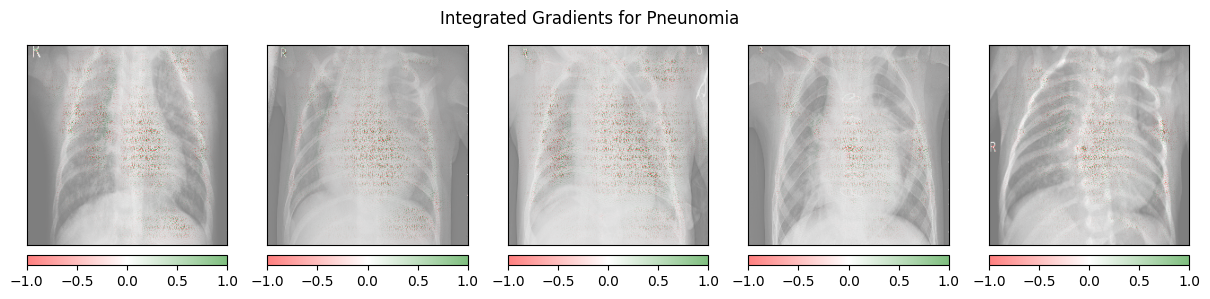

In [15]:
plt.rcParams["figure.figsize"] = (15,3)
fig, ax = plt.subplots(1, 5)
fig.suptitle("Integrated Gradients for Pneunomia")

for attr, img, axis in zip(pneunomia_attr, pneunomia, ax):

  original_image = np.transpose(img.cpu().detach().numpy(), (1, 2, 0))
  _ = viz.visualize_image_attr(attr, original_image, method="blended_heat_map",sign="all",
                            show_colorbar=True, plt_fig_axis=(fig, axis), use_pyplot=False)

plt.show()

### Plot 5 negative samples

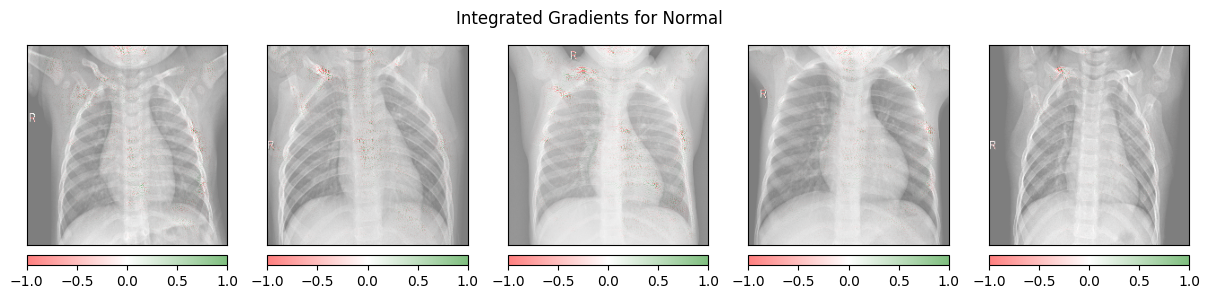

In [29]:
plt.rcParams["figure.figsize"] = (15,3)
fig, ax = plt.subplots(1, 5)
fig.suptitle("Integrated Gradients for Normal")

for attr, img, axis in zip(normal_attr, normal, ax):

  original_image = np.transpose(img.cpu().detach().numpy(), (1, 2, 0))
  _ = viz.visualize_image_attr(attr, original_image, method="blended_heat_map",sign="all",
                            show_colorbar=True, plt_fig_axis=(fig, axis), use_pyplot=False)

plt.show()

## Q4: Grad-CAM

In [17]:
target_layers = model.layer13
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)

In [18]:
pneunomia_cam = cam(input_tensor=pneunomia)

In [27]:
normal_cam = cam(input_tensor=normal)

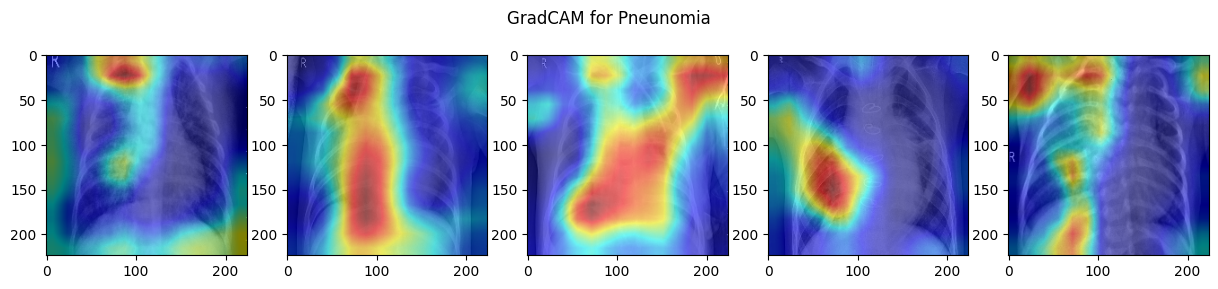

In [26]:
plt.rcParams["figure.figsize"] = (15,3)
fig, ax = plt.subplots(1, 5)
fig.suptitle("GradCAM for Pneunomia")

for gray_cam, img, axis in zip(pneunomia_cam, pneunomia, ax):
  
  original_image = np.transpose(img.cpu().detach().numpy(), (1, 2, 0))
  visualization = show_cam_on_image(original_image, gray_cam, use_rgb=True)
  axis.imshow(visualization)

plt.show()

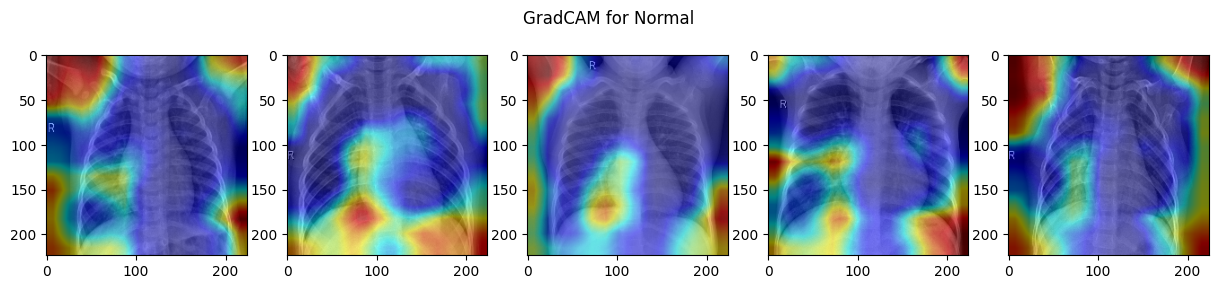

In [28]:
plt.rcParams["figure.figsize"] = (15,3)
fig, ax = plt.subplots(1, 5)
fig.suptitle("GradCAM for Normal")

for gray_cam, img, axis in zip(normal_cam, normal, ax):
  
  original_image = np.transpose(img.cpu().detach().numpy(), (1, 2, 0))
  visualization = show_cam_on_image(original_image, gray_cam, use_rgb=True)
  axis.imshow(visualization)

plt.show()